In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
from source.tserie import TSerie
from source.read_ontario import read_ontario
from source.utils import commonWindows
from source.torch_utils import getContrastiveFeatures

VIS_PATH = 'visualizations'
SMOOTH = 50 # -1 if you don't want to smooth the data otherwise the size of the smooth window
LOSS = 'SimCLR' # SupConLoss | SimCLR
MODE = 'shape' # subsequences - shape
EPOCHS = 150
BATCH_SIZE = 32
ENC_SIZE = 8
POLLUTANTS = ['PM25', 'NO2'] # ['NO', 'NOx', 'NO2', 'SO2', 'CO', 'O3', 'PM25']
CONV_FILTERS = [16, 32, 32]
CONV_KERNELS = [7, 7, 7]
UMAP_NEIGHBORS = 15


/home/texs/anaconda3/envs/contrastive/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Years case

In [2]:
windows_map = read_ontario(granularity='years')
pollutans = POLLUTANTS
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

/home/texs/anaconda3/envs/contrastive/lib/python3.10/site-packages/numpy/lib/format.py:747: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  array = pickle.load(fp, **pickle_kwargs)


In [3]:
month_ids = [date.month for date in dates]
year_ids = [date.year for date in dates]


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, len(month_ids) + 1)}
years_map = {int(year) : str(year) for year in year_ids}

In [4]:
mts = TSerie(X=windows, y = station_ids)

if SMOOTH > 0:
    mts.smooth(window_size=SMOOTH)

if MODE == 'shape':
    mts.shapeNormalizization()
else:
    mts.minMaxNormalizization()


Loaded mts - N: 180, T: 365, D: 2 
(180, 2, 365)


In [5]:

mts.features = getContrastiveFeatures(
    mts.X.transpose([0, 2, 1]), mts.y, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    loss_metric= LOSS, 
    mode = MODE, 
    encoding_size = ENC_SIZE,
    conv_filters = CONV_FILTERS,
    conv_kernels = CONV_KERNELS,
)

Epoch[1] Train loss    avg: 3.2083855072657266
Epoch[10] Train loss    avg: 1.5573779543240864
Epoch[20] Train loss    avg: 1.3676711122194927
Epoch[30] Train loss    avg: 1.3260427316029866
Epoch[40] Train loss    avg: 1.3219480713208516
Epoch[50] Train loss    avg: 1.2665870189666748
Epoch[60] Train loss    avg: 1.241196076075236
Epoch[70] Train loss    avg: 1.2476935386657715
Epoch[80] Train loss    avg: 1.2221071124076843
Epoch[90] Train loss    avg: 1.2107341090838115
Epoch[100] Train loss    avg: 1.1959134737650554
Epoch[110] Train loss    avg: 1.1888150374094646
Epoch[120] Train loss    avg: 1.1840917666753132
Epoch[130] Train loss    avg: 1.1882874369621277
Epoch[140] Train loss    avg: 1.1805674036343892
Epoch[150] Train loss    avg: 1.188632647196452


In [6]:
import umap

reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=UMAP_NEIGHBORS)
coords = reducer.fit_transform(mts.features)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


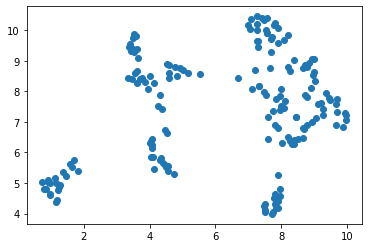

In [7]:
import matplotlib.pyplot as plt
plt.scatter(coords[:, 0], coords[:, 1])

In [8]:
from server.source.storage import MTSStorage

storage = MTSStorage(os.path.join(VIS_PATH ,'ontario_years.npy'))    
# storage.delete()
storage.load()

dimensions = pollutans
data = np.concatenate([mts.X_orig, mts.X], axis=2) 
storage.add_mts(
    '_'.join(POLLUTANTS) , data , 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'station': station_ids, 'months': month_ids, 'years': year_ids}, 
    labelsNames={'station': stations_map, 'months': months_map, 'years': years_map}, 
    coords = {
        'coords': coords,
    }
)


storage.save()

mts shape: N: 180 -  T: 365 - D: 4
